<a href="https://colab.research.google.com/github/jdexbarr/Phishing-Detection/blob/main/Phishing_email_detector_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Libraries to manage data
import pandas as pd
import numpy as np

# libraries for graphs
import matplotlib.pyplot as plt
import seaborn as sns

# scikit-learn libraries for splitting data, modeling, and evaluation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
)

#Utilities
import re
import pickle
from urllib.parse import urlparse
import warnings
import joblib
warnings.filterwarnings('ignore')

# Style of graphs
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')


DOWNLOAD DATASETS AND SHOW SIZES

In [ ]:
# Read the 4 csv, 2 with text and 2 with numeric features
df_text1 = pd.read_csv("Phishing_Email.csv")
df_text2 = pd.read_csv("spam_ham_dataset.csv")
df_feat1 = pd.read_csv("Phishing_Legitimate_full.csv")
df_feat2 = pd.read_csv("email_phishing_data.csv")

# Columns and registers in each file
print("Files download:")
for name, df in zip(
    ["Phishing_Email", "Spam/Ham", "Phishing_Legitimate_full", "Email_phishing_data"],
    [df_text1, df_text2, df_feat1, df_feat2]
):
    print(f"{name}: {df.shape}")

Files download:
Phishing_Email: (18650, 3)
Spam/Ham: (5171, 4)
Phishing_Legitimate_full: (10000, 50)
Email_phishing_data: (524846, 9)


Clean and unify phishing_email.csv
and spam_ham_dataset.csv


In [ ]:
# read again datasets
df_pe = pd.read_csv("Phishing_Email.csv")
df_sh = pd.read_csv("spam_ham_dataset.csv")

# names of columns
print("Columns Phishing_Email:", df_pe.columns.tolist())
print("Columns spam_ham_dataset:", df_sh.columns.tolist())




#   Phishing_Email.csv


# Extract the text and the label (phishing/safe)
pe_text = df_pe["Email Text"]
pe_label_raw = df_pe["Email Type"]

# Labels as 0/1
# Safe Email = 0, Phishing Email = 1
pe_label = (
    pe_label_raw
    .astype(str)
    .str.strip()
    .str.lower()
    .map({
        "phishing email": 1,
        "phishing": 1,
        "safe email": 0,
        "safe": 0,
        "legitimate": 0
    })
)

# keep files with text and valid labels

pe_mask = (~pe_text.isna()) & (~pe_label.isna())
pe_text = pe_text[pe_mask]
pe_label = pe_label[pe_mask]

print("\nPhishing_Email valid:", pe_text.shape[0], "emails")



# spam_ham_dataset.csv


# Eliminate indexes
if "Unnamed: 0" in df_sh.columns:
    df_sh = df_sh.drop(columns=["Unnamed: 0"])

# Email text
sh_text = df_sh["text"]

# Label
# Convert labels to 0/1
if "label_num" in df_sh.columns:
    sh_label = df_sh["label_num"]
else:
    sh_label = (
        df_sh["label"]
        .astype(str)
        .str.lower()
        .map({"spam": 1, "ham": 0})
    )

# keep files with text and valid labels
sh_mask = (~sh_text.isna()) & (~sh_label.isna())
sh_text = sh_text[sh_mask]
sh_label = sh_label[sh_mask]

print("spam_ham_dataset válido:", sh_text.shape[0], "correos")


# df_text final, combine both text dataset into a single one

# join dataset and their labels
all_text = pd.concat([pe_text, sh_text], ignore_index=True)
all_label = pd.concat([pe_label, sh_label], ignore_index=True)

df_text = pd.DataFrame({
    "text": all_text,
    "label": all_label
})

print("\n combined text dataset shape:", df_text.shape)
print(df_text["label"].value_counts())
df_text.head()


Columns Phishing_Email: ['Unnamed: 0', 'Email Text', 'Email Type']
Columns spam_ham_dataset: ['Unnamed: 0', 'label', 'text', 'label_num']

Phishing_Email valid: 18634 emails
spam_ham_dataset válido: 5171 correos

 combined text dataset shape: (23805, 2)
label
0    14994
1     8811
Name: count, dtype: int64


,text,label
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",0
1,the other side of * galicismos * * galicismo *...,0
2,re : equistar deal tickets are you still avail...,0
3,\nHello I am your hot lil horny toy.\n I am...,1
4,software at incredibly low prices ( 86 % lower...,1


Prepare numeric datasets and normalize labels

In [ ]:
df_feat1 = pd.read_csv("Phishing_Legitimate_full.csv")
df_feat2 = pd.read_csv("email_phishing_data.csv")

print("Columnas Phishing_Legitimate_full:", df_feat1.columns.tolist()[:10], "...")
print("Columnas email_phishing_data:", df_feat2.columns.tolist())
print("\n Original shapes:")
print("Phishing_Legitimate_full:", df_feat1.shape)
print("email_phishing_data:", df_feat2.shape)

# Normalize labels as 0/1

# Dataset 1, classlabel as 'phishing'/ 'legitimate'
# renamed CLASS_LABEL to 'label' to make it more consistent
df_feat1= df_feat1.rename(columns={'CLASS_LABEL': 'label'})

df_feat1["label"]= (
    df_feat1["label"]
    .astype(str)
    .str.lower()
    .map({
        "phishing": 1,
        "legitimate": 0,
        "safe email": 0,
        "safe": 0
    })
)

# drops files with unvalid labels
df_feat1 = df_feat1.dropna(subset=["label"])

print("\nDistribución etiquetas feat1:")
print(df_feat1["label"].value_counts())


# Dataset 2, email_phishing.csv

#label column is type "object", map strings to 0/1
print("\n df_feat2['label'] TYPE:", df_feat2["label"].dtype)

if df_feat2["label"].dtype == " O":
    df_feat2["label"]= (
    df_feat2["label"]
    .astype(str)
    .str.lower()
    .map({
        "phishing": 1,
        "legitimate": 0,
        "spam": 1,
        "ham": 0,
        "safe email": 0,
        "safe": 0
    })
)

    #Remove rows with invalid label

df_feat2 = df_feat2.dropna(subset=["label"])

print("\n feat2 label distribution:")
print(df_feat2["label"].value_counts())






Columnas Phishing_Legitimate_full: ['id', 'NumDots', 'SubdomainLevel', 'PathLevel', 'UrlLength', 'NumDash', 'NumDashInHostname', 'AtSymbol', 'TildeSymbol', 'NumUnderscore'] ...
Columnas email_phishing_data: ['num_words', 'num_unique_words', 'num_stopwords', 'num_links', 'num_unique_domains', 'num_email_addresses', 'num_spelling_errors', 'num_urgent_keywords', 'label']

 Original shapes:
Phishing_Legitimate_full: (10000, 50)
email_phishing_data: (524846, 9)

Distribución etiquetas feat1:
Series([], Name: count, dtype: int64)

 df_feat2['label'] TYPE: int64

 feat2 label distribution:
label
0    517897
1      6949
Name: count, dtype: int64


In [ ]:
# just keep a dataset with numeric columns and and labels in each dataset


# This function receives a DataFrame and returns :
#  numeric columns
#  "label" column
def numeric_with_labels(df):

   numeric_cols = df.select_dtypes(include=["number"]).columns.tolist()
   if "label" not in numeric_cols:
        numeric_cols.append("label")  # keep the label
   return df[numeric_cols]

# apply the function to the two numeric datasets
df_feat1_num = numeric_with_labels(df_feat1)
df_feat2_num = numeric_with_labels(df_feat2)

print("feat1 num shape:", df_feat1_num.shape)
print("feat2 num shape:", df_feat2_num.shape)


# Join both datasets

df_features = pd.concat([df_feat1_num, df_feat2_num], ignore_index=True, sort=True)

# Fill each space that has NaNs with 0s, this is when the columnn just exists in one of the datasets and not both
df_features = df_features.fillna(0)

print("\n combined features dataset shape:", df_features.shape)
print(df_features["label"].value_counts)
df_features.head()

feat1 num shape: (0, 50)
feat2 num shape: (524846, 9)

 combined features dataset shape: (524846, 58)
<bound method IndexOpsMixin.value_counts of 0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
524841    0.0
524842    1.0
524843    0.0
524844    0.0
524845    0.0
Name: label, Length: 524846, dtype: float64>


,AbnormalExtFormActionR,AbnormalFormAction,AtSymbol,DomainInPaths,DomainInSubdomains,DoubleSlashInPath,EmbeddedBrandName,ExtFavicon,ExtFormAction,ExtMetaScriptLinkRT,...,id,label,num_email_addresses,num_links,num_spelling_errors,num_stopwords,num_unique_domains,num_unique_words,num_urgent_keywords,num_words
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,52.0,0.0,94.0,0.0,140.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,0.0,5.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,15.0,0.0,32.0,0.0,34.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,6.0,0.0,6.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,9.0,0.0,9.0


In [ ]:
# Save both datasets

df_text.to_csv("clean_text_dataset.csv", index=False)
df_features.to_csv("clean_numeric_dataset.csv", index=False)

print("Saved datasets:")
print("clean_text_dataset.csv")
print("clean_numeric_dataset.csv")

Saved datasets:
clean_text_dataset.csv
clean_numeric_dataset.csv


In [ ]:
# Load clean text dataset and view distribution
df_text = pd.read_csv("clean_text_dataset.csv")
print("Shape of text dataset:", df_text.shape)
print("First rows:")
print(df_text.head())

print("Distribution of labels")
print(df_text["label"].value_counts())


Shape of text dataset: (23805, 2)
First rows:
                                                text  label
0  re : 6 . 1100 , disc : uniformitarianism , re ...      0
1  the other side of * galicismos * * galicismo *...      0
2  re : equistar deal tickets are you still avail...      0
3  \nHello I am your hot lil horny toy.\n    I am...      1
4  software at incredibly low prices ( 86 % lower...      1
Distribution of labels
label
0    14994
1     8811
Name: count, dtype: int64


In [ ]:
# TRAIN AND SPLIT OF TEXT
# X = text of the emails
# y = label (0 = legitimate, 1 = phishing/spam)
X = df_text["text"]
y = df_text["label"]


#  training (80%) and testing (20%)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y   # maintains the class ratio
)

print("Training size: ", X_train.shape[0])
print("Test size: ", X_test.shape[0])


Training size:  19044
Test size:  4761


In [ ]:
# THE 3 MODELS, THE PIPELINES

# Logistic regression

# TfidfVectorizer: transforms text into numeric vectors.

text_clf_lr = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=20000,      # maximum number of words/features
        ngram_range=(1, 2),      # Use unigrams and bigrams
        stop_words="english"     # Remove very common English words
    )),
    ('clf', LogisticRegression(max_iter=1000, n_jobs=-1))
])


# RANDOM FOREST

text_clf_rf = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=20000,
        ngram_range=(1,2),
        stop_words="english"
    )),
    ("clf", RandomForestClassifier(
        n_estimators=200,        # number of trees
        random_state=42,
        n_jobs=-1
    ))
])


# NAIVE BAYES

text_clf_nb = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=20000,
        ngram_range=(1, 2),
        stop_words="english"
    )),
    ('clf', MultinomialNB())
])

print("Defined pipelines LR, RF, NB")


Defined pipelines LR, RF, NB


In [ ]:
# TRAINING THE MODELS

print("\nLogistic regression training: ")
text_clf_lr.fit(X_train, y_train)
print("LR trained")

print("\nRandom forest training: ")
text_clf_rf.fit(X_train, y_train)
print("RF trained")

print("\nNaive Bayes training: ")
text_clf_nb.fit(X_train, y_train)
print("NB trained")


Logistic regression training: 
LR trained

Random forest training: 
RF trained

Naive Bayes training: 
NB trained


In [ ]:
# EVALUATE THE 3 MODELS

def evaluate_models(model, X_test, y_test):
  # Predictions (class 0/1)
    y_pred = model.predict(X_test)
    # Chance of being class 1
    y_probability = model.predict_proba(X_test)[:, 1]

    # Standard ranking metrics

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    area_under_curve = roc_auc_score(y_test, y_probability)

    # Dictionary to use later

    return{
        "y_pred": y_pred,
        "y_probability": y_probability,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1,
        "ROC_AUC": area_under_curve
    }

# EVALUATION OF EACH MODEL

results = {}

# save the results of each model in the results dictionary

results["Logistic Regression"] = evaluate_models(text_clf_lr, X_test, y_test)
results["Random Forest"] = evaluate_models(text_clf_rf, X_test, y_test)
results["Naive Bayes"] = evaluate_models(text_clf_nb, X_test, y_test)

# COMPARATION TABLE TO CHOOSE THE ONE WITH THE HIGHEST PRECISION

rows = []

for name, res in results.items():
    rows.append({
        "Model": name,
        "Accuracy": res["Accuracy"],
        "Precision": res["Precision"],
        "Recall": res["Recall"],
        "F1-score": res["F1-score"],
        "ROC_AUC": res["ROC_AUC"]
    })

comparison = pd.DataFrame(rows)
print("Model comparison: \n")
print(comparison)

# Select the one with highest precision (F1-score)

best_row = comparison.loc[comparison["F1-score"].idxmax()]
best_name = best_row["Model"]

best_result = results[best_name]

if best_name == "Logistic Regression":
    best_model = text_clf_lr
elif best_name == "Random Forest":
    best_model = text_clf_rf
else:
    best_model = text_clf_nb

print("\nModel with the highest F1-SCORE: ", best_name)
print(best_row)



Model comparison: 

                 Model  Accuracy  Precision    Recall  F1-score   ROC_AUC
0  Logistic Regression  0.971855   0.953735  0.971056  0.962317  0.996537
1        Random Forest  0.972695   0.947859  0.980136  0.963728  0.996460
2          Naive Bayes  0.959042   0.957919  0.930193  0.943853  0.994085

Model with the highest F1-SCORE:  Random Forest
Model        Random Forest
Accuracy          0.972695
Precision         0.947859
Recall            0.980136
F1-score          0.963728
ROC_AUC            0.99646
Name: 1, dtype: object


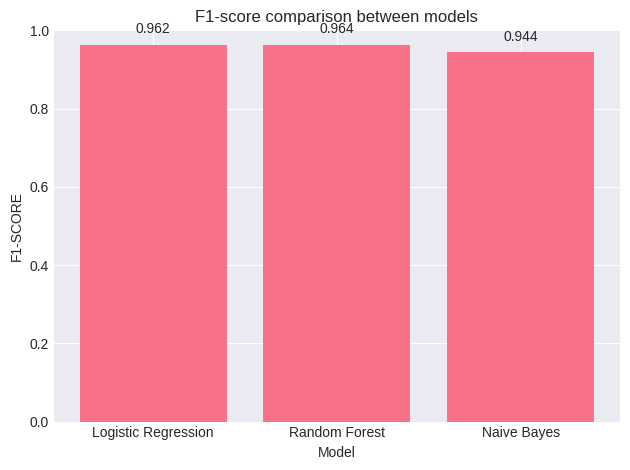

In [ ]:
# COMPARATIVE F-1 SCORE

models = comparison["Model"].values
f1_values = comparison["F1-score"].values


plt.figure()
plt.bar(models, f1_values)
plt.title("F1-score comparison between models")
plt.ylim(0,1)
for i, j in enumerate(f1_values):
  plt.text(i, j + 0.03, f"{j:.3f}", ha="center")

plt.xlabel("Model")
plt.ylabel("F1-SCORE")
plt.tight_layout()
plt.savefig("F1-COMPARISON.png", dpi=300)
plt.show()


In [ ]:
# SAVING MODEL WITH HIGHEST F1-SCORE

model_file_name = best_name.lower().replace(" ", "_")

model_filename = f"phishing_text_model_{model_file_name}.joblib"
joblib.dump(best_model, model_filename)

print(f"Model saved as: {model_filename} ")
print(f"(Highest F1-SCORE: {best_row['F1-score']:.4f}, Model: {best_name})")

Model saved as: phishing_text_model_random_forest.joblib 
(Highest F1-SCORE: 0.9637, Model: Random Forest)


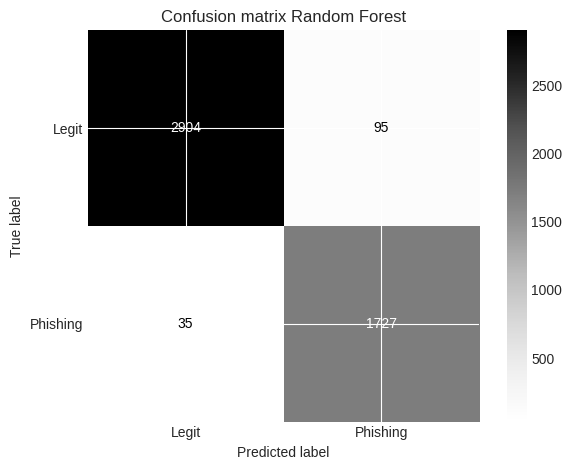

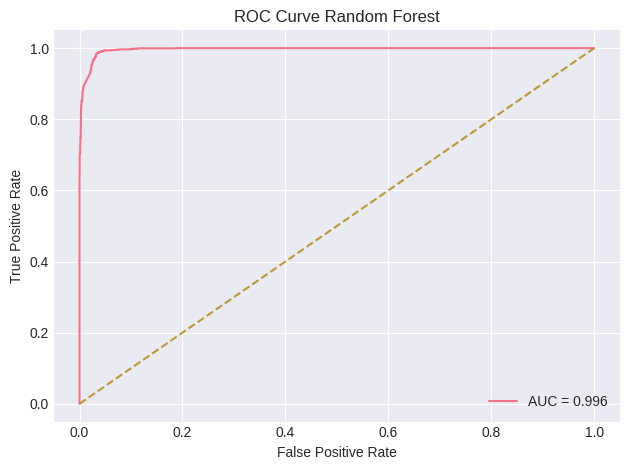

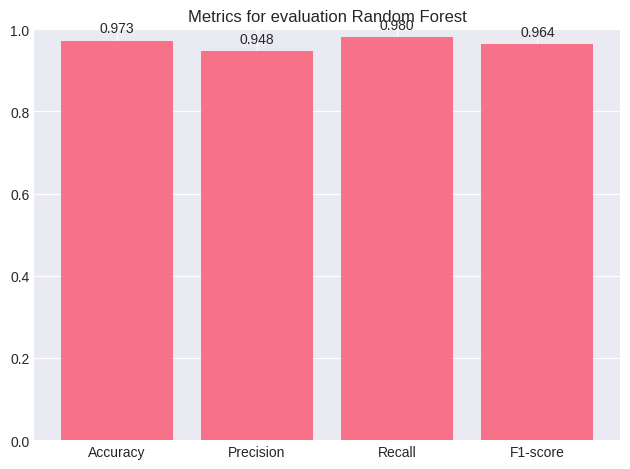

Graphs saved for the chosen model: 
 Confusion_matrix_random_forest.png
 Roc_curve_random_forest.png
 Metrics_bars_random_forest.png
Also: F1-COMPARISON.png


In [ ]:
# GRAPH OF THE CHOSEN MODEL

y_pred = best_result["y_pred"]
y_probability = best_result["y_probability"]


# CONFUSION MATRIX GRAPH

confu_matrix = confusion_matrix(y_test, y_pred)

plt.figure()
plt.imshow(confu_matrix, interpolation="nearest")
plt.title(f"Confusion matrix {best_name}")
plt.colorbar()
tick_marks = [0,1]
plt.xticks(tick_marks, ["Legit", "Phishing"])
plt.yticks(tick_marks, ["Legit", "Phishing"])
plt.xlabel("Predicted label")
plt.ylabel("True label")


# write the values ​​inside each box

thresh = confu_matrix.max() / 2.0
for i in range(confu_matrix.shape[0]):
    for j in range(confu_matrix.shape[1]):
        plt.text(j, i, format(confu_matrix[i, j], "d"),
                 ha="center", va="center",
                 color="white" if confu_matrix[i, j] > thresh else "black")



plt.tight_layout()
plt.savefig(f"confusion_matrix_{model_file_name}.png", dpi=300)
plt.show()


# ROC CURVE

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_probability)

plt.figure()
plt.plot(false_positive_rate, true_positive_rate, label=f"AUC = {best_result['ROC_AUC']:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.title(f"ROC Curve {best_name}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig(f"roc_curve_{model_file_name}.png", dpi=300)
plt.show()


# BARS TO MEASURE THE METRICS OF THE CHOSEN MODEL

metrics_names = ["Accuracy", "Precision", "Recall", "F1-score"]
metrics_values = [
    best_row["Accuracy"],
    best_row["Precision"],
    best_row["Recall"],
    best_row["F1-score"]
]

plt.figure()
plt.bar(metrics_names, metrics_values)
plt.ylim(0,1)
plt.title(f"Metrics for evaluation {best_name}")

for i, j in enumerate(metrics_values):
    plt.text(i, j + 0.02, f"{j:.3f}", ha="center")
plt.tight_layout()

plt.savefig(f"metrics_bars{model_file_name}.png", dpi=300)
plt.show()

print("Graphs saved for the chosen model: ")
print(f" Confusion_matrix_{model_file_name}.png")
print(f" Roc_curve_{model_file_name}.png")
print(f" Metrics_bars_{model_file_name}.png")
print("Also: F1-COMPARISON.png")



FEATURE ENGINEERING


In [ ]:
# load the clean numeric dataset
df_features = pd.read_csv("clean_numeric_dataset.csv")
print("Shape of numeric dataset:", df_features.shape)
print("First rows:" , df_features.columns[:10].tolist())
print("Distribution of labels")
print(df_features["label"].value_counts())

df_features.head()

Shape of numeric dataset: (524846, 58)
First rows: ['AbnormalExtFormActionR', 'AbnormalFormAction', 'AtSymbol', 'DomainInPaths', 'DomainInSubdomains', 'DoubleSlashInPath', 'EmbeddedBrandName', 'ExtFavicon', 'ExtFormAction', 'ExtMetaScriptLinkRT']
Distribution of labels
label
0.0    517897
1.0      6949
Name: count, dtype: int64


,AbnormalExtFormActionR,AbnormalFormAction,AtSymbol,DomainInPaths,DomainInSubdomains,DoubleSlashInPath,EmbeddedBrandName,ExtFavicon,ExtFormAction,ExtMetaScriptLinkRT,...,id,label,num_email_addresses,num_links,num_spelling_errors,num_stopwords,num_unique_domains,num_unique_words,num_urgent_keywords,num_words
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,52.0,0.0,94.0,0.0,140.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,0.0,5.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,15.0,0.0,32.0,0.0,34.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,6.0,0.0,6.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,9.0,0.0,9.0


In [ ]:
# Separate X, y and remove highly correlated constant columns

from sklearn.feature_selection import VarianceThreshold

y_num = df_features["label"]
X_num = df_features.drop(columns=["label"])


print("Shape X_num:", X_num.shape)
print("Shape y_num:", y_num.shape)

# drop columns with variance 0, which are constants

selector = VarianceThreshold(threshold=0.0)
selector.fit(X_num)


mask = selector.get_support()
columns_kept = X_num.columns[mask]

reduced_X_num = X_num[columns_kept]

print("Columns before dropping:", X_num.shape[1])
print("Columns after removing constants:", reduced_X_num.shape[1])

# Drop columns highly correlated

correlated_matrix = reduced_X_num.corr().abs()
upper = correlated_matrix.where(
    np.triu(np.ones(correlated_matrix.shape), k=1).astype(bool)
)


to_drops = [column for column in upper.columns if any(upper[column] > 0.95)]
print("Columns to remove", len(to_drops))

reduced_X_num2 = reduced_X_num.drop(columns=to_drops)

print("Columns after removing highly correlated:", reduced_X_num2.shape[1])

Shape X_num: (524846, 57)
Shape y_num: (524846,)
Columns before dropping: 57
Columns after removing constants: 8
Columns to remove 1
Columns after removing highly correlated: 7


In [ ]:
# NUMERIC BASELINE WITH RANDOM FOREST
# Divide into train/test
X_train_num, X_test_num, y_train_num, y_test_num = train_test_split(
    reduced_X_num2, y_num,
    test_size=0.2,
    random_state=42,
    stratify=y_num
)

# define a Random Forest for numerical features

rf_clf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
# train the model
rf_clf.fit(X_train_num, y_train_num)

# Predictions on the test set
y_predict_num = rf_clf.predict(X_test_num)

print("RANDOM FOREST WITH FILTERED NUMERICAL FEATURES")
print("Accuracy: ", accuracy_score(y_test_num, y_predict_num))
print("Precision: ", precision_score(y_test_num, y_predict_num))
print("Recall: ", recall_score(y_test_num, y_predict_num))
print("F1-score: ", f1_score(y_test_num, y_predict_num))
print("\n Report of classification: ", classification_report(y_test_num, y_predict_num))


RANDOM FOREST WITH FILTERED NUMERICAL FEATURES
Accuracy:  0.9884062112984662
Precision:  0.7146401985111662
Recall:  0.20719424460431654
F1-score:  0.32124930284439485

 Report of classification:                precision    recall  f1-score   support

         0.0       0.99      1.00      0.99    103580
         1.0       0.71      0.21      0.32      1390

    accuracy                           0.99    104970
   macro avg       0.85      0.60      0.66    104970
weighted avg       0.99      0.99      0.99    104970



In [ ]:
# Select top features and save numeric model

# Importance of each feature according to the Random Forest
importance = rf_clf.feature_importances_
features_names = reduced_X_num2.columns

# higher to lower importance
feature_importance = pd.Series(importance, index=features_names).sort_values(ascending=False)

print("Top 20 features: \n")
print(feature_importance.head(20))

TOP_N = 20
top_features = feature_importance.head(TOP_N).index.tolist()

print("\n Features that would be used for the reduced model: ", TOP_N, )
print(top_features)

# Train model with top features

# top columns in train and test

X_train_top = X_train_num[top_features]
X_test_top = X_test_num[top_features]

random_forest_top = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

# trained the "reduced" random forest
random_forest_top.fit(X_train_top, y_train_num)
y_predict_top = random_forest_top.predict(X_test_top)



print("RANDOM FOREST WITH TOP NUMERICAL FEATURES")
print("Accuracy:", accuracy_score(y_test_num, y_predict_top))
print("Precision:", precision_score(y_test_num, y_predict_top))
print("Recall:", recall_score(y_test_num, y_predict_top))
print("F1-score:", f1_score(y_test_num, y_predict_top))
print("\n Report of classification:\n", classification_report(y_test_num, y_predict_top))


# SAVING MODEL

joblib.dump(random_forest_top, "phishing_numeric_model.joblib")

with open("numeric_top_features.txt", "w") as f:
    for col in top_features:
        f.write(col + "\n")

print("\ Numerical model saved as: phishing_numeric_model.joblib")
print("Top features saved as: numeric_top_features.txt")

Top 20 features: 

num_unique_words       0.387257
num_stopwords          0.333367
num_spelling_errors    0.220160
num_urgent_keywords    0.020063
num_links              0.014112
num_email_addresses    0.013420
num_unique_domains     0.011620
dtype: float64

 Features that would be used for the reduced model:  20
['num_unique_words', 'num_stopwords', 'num_spelling_errors', 'num_urgent_keywords', 'num_links', 'num_email_addresses', 'num_unique_domains']
RANDOM FOREST WITH TOP NUMERICAL FEATURES
Accuracy: 0.9883966847670763
Precision: 0.7139303482587065
Recall: 0.20647482014388488
F1-score: 0.3203125

 Report of classification:
               precision    recall  f1-score   support

         0.0       0.99      1.00      0.99    103580
         1.0       0.71      0.21      0.32      1390

    accuracy                           0.99    104970
   macro avg       0.85      0.60      0.66    104970
weighted avg       0.99      0.99      0.99    104970

\ Numerical model saved as: phishing_n

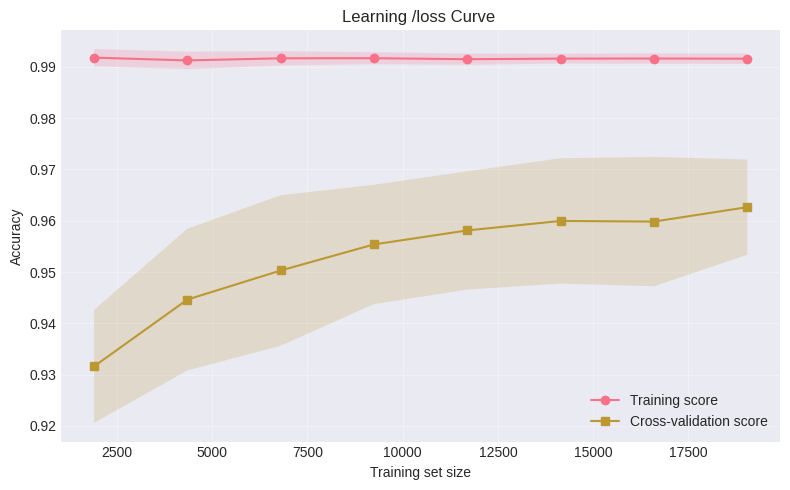

In [ ]:
from sklearn.model_selection import learning_curve


# extract text and labels columns

X_full = df_text["text"]
y_full = df_text["label"]

# Calculate the learning curves
train_sizes, train_scores, test_scores = learning_curve(
    best_model,
    X_full,        # input features
    y_full,        # target labels
    cv=5,          # 5-fold cross-validation
    scoring="accuracy",     # performance metric
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 8),
    shuffle=True,
    random_state=42
)

# Calculate the mean and standard deviation of training and test scores

train_mean = train_scores.mean(axis=1)
train_std  = train_scores.std(axis=1)
test_mean  = test_scores.mean(axis=1)
test_std   = test_scores.std(axis=1)

plt.figure(figsize=(8, 5))
plt.title("Learning /loss Curve ")

# Plot the training scores with confidence intervals
plt.plot(train_sizes, train_mean, label="Training score", marker="o")
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.2)

# Plot the cross-validation scores with confidence intervals
plt.plot(train_sizes, test_mean, label="Cross-validation score", marker="s")
plt.fill_between(train_sizes, test_mean-test_std, test_mean+test_std, alpha=0.2)

plt.xlabel("Training set size")
plt.ylabel("Accuracy")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
# save image
plt.savefig("learning_curve_phishguard.png", dpi=300)
plt.show()
